# HPA Usage
Pesquisa por código no Github, buscando por arquivos que contenham definições de HPA (HorizontalPodAutoscaler).

Filtra por repositórios com alguma relevância (número de estrelas) e apresenta estatísticas.

Os arquivos encontrados após o filtro são salvos no diretório `search_results`.

## Preparando o ambiente

In [1]:
import utils
import os
import glob
import time
import re
import json
import requests
import yaml
from pathlib import Path
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

from joblib import Parallel, delayed
from dotenv import dotenv_values
from ghapi.core import GhApi, HTTP422UnprocessableEntityError, HTTP404NotFoundError, HTTP403ForbiddenError
import fastcore
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('bmh')


In [2]:
config = {
    **os.environ,
    **dotenv_values(".env")
}
github = GhApi(token=config['GITHUB_TOKEN'])


In [11]:
gh_limit = github.rate_limit.get()

print(int(datetime.timestamp(datetime.now())),
      datetime.now().replace(microsecond=0))
print(gh_limit['resources']['core']['reset'],
      datetime.fromtimestamp(gh_limit['resources']['core']['reset']))
display(gh_limit['resources'])


1743939864 2025-04-06 08:44:24
1743943437 2025-04-06 09:43:57


```json
{ 'actions_runner_registration': { 'limit': 10000,
                                   'remaining': 10000,
                                   'reset': 1743943463,
                                   'used': 0},
  'audit_log': { 'limit': 1750,
                 'remaining': 1750,
                 'reset': 1743943463,
                 'used': 0},
  'audit_log_streaming': { 'limit': 15,
                           'remaining': 15,
                           'reset': 1743943463,
                           'used': 0},
  'code_scanning_autofix': { 'limit': 10,
                             'remaining': 10,
                             'reset': 1743939923,
                             'used': 0},
  'code_scanning_upload': { 'limit': 1000,
                            'remaining': 1000,
                            'reset': 1743943463,
                            'used': 0},
  'code_search': {'limit': 10, 'remaining': 10, 'reset': 1743939923, 'used': 0},
  'core': {'limit': 5000, 'remaining': 4783, 'reset': 1743943437, 'used': 217},
  'dependency_snapshots': { 'limit': 100,
                            'remaining': 100,
                            'reset': 1743939923,
                            'used': 0},
  'graphql': {'limit': 5000, 'remaining': 5000, 'reset': 1743943463, 'used': 0},
  'integration_manifest': { 'limit': 5000,
                            'remaining': 5000,
                            'reset': 1743943463,
                            'used': 0},
  'scim': {'limit': 15000, 'remaining': 15000, 'reset': 1743943463, 'used': 0},
  'search': {'limit': 30, 'remaining': 30, 'reset': 1743939923, 'used': 0},
  'source_import': { 'limit': 100,
                     'remaining': 100,
                     'reset': 1743939923,
                     'used': 0}}
```

## Definindo Funções Principais

In [34]:
def wait_for_reset(resource):
    limit = github.rate_limit.get()['resources'][resource]
    reset_time = datetime.fromtimestamp(limit['reset'])
    now = datetime.today().replace(microsecond=0)
    if limit['remaining'] <= 1:
        sleep_duration = reset_time - now
        if sleep_duration.total_seconds() < 0:
            sleep_duration = timedelta(seconds=60)
        print(
            f"Waiting for {sleep_duration.total_seconds()} seconds until {reset_time}")
        time.sleep(sleep_duration.total_seconds())


def search_code_hpa():
    """
    Realiza a pesquisa por arquivos de código contendo definição de um HPA ("kind: HorizontalPodAutoscaler")

    Por limitação da API, a cada pesquisa, um máximo de 1000 itens será retornado.
    """
    result_items = []
    page = 1

    # search_result acumula cada página da pesquisa
    search_result = None

    # Carrega as páginas da pesquisa
    while search_result is None or len(result_items) < search_result['total_count']:
        wait_for_reset('code_search')
        print(f"Carregando página {page}")
        time.sleep(1)
        try:
            search_result = github.search.code(
                q='"kind: HorizontalPodAutoscaler" language:yaml', per_page=100, page=page)
            result_items.extend(search_result['items'])
            page += 1
        except HTTP422UnprocessableEntityError as e:
            return result_items


def get_repo_details(row):
    wait_for_reset('core')
    name_parts = re.split(r'/', row['repo_name'])

    try:
        repo_details = github.repos.get(
            owner=name_parts[0], repo=name_parts[1])
    except HTTP403ForbiddenError:
        print("Limit reached")
        wait_for_reset('core')
        repo_details = github.repos.get(
            owner=name_parts[0], repo=name_parts[1])
        print(f"Done waiting. repo_details is None: {repo_details is None}")
    except:  # (HTTP404NotFoundError, fastcore.net.HTTP404NotFoundError):
        return {
            'stargazers_count': None,
            'created_at': None,
            'pushed_at': None
        }

    return {
        'stargazers_count': repo_details['stargazers_count'],
        'created_at': repo_details['created_at'],
        'pushed_at': repo_details['pushed_at']
    }


def get_file_commit(row):
    wait_for_reset('core')
    name_parts = re.split(r'/', row['repo_name'])

    try:
        commits = github.repos.list_commits(
            owner=name_parts[0], repo=name_parts[1], path=row['file_path'], per_page=1)
    except HTTP403ForbiddenError:
        print("Limit reached")
        wait_for_reset('core')
        commits = github.repos.list_commits(
            owner=name_parts[0], repo=name_parts[1], path=row['file_path'], per_page=1)
    except (HTTP404NotFoundError, fastcore.net.HTTP404NotFoundError):
        return {
            'file_committed_at': None,
            'message': None
        }

    if len(commits) == 0:
        return {
            'file_committed_at': None,
            'message': None
        }

    return {
        'file_committed_at': commits[0]['commit']['author']['date'],
        'message': commits[0]['commit']['message']
    }


def extract_hpa(yaml_content):
    hpa_list = []
    for doc in yaml_content:
        if isinstance(doc, dict) and doc.get('kind') == "HorizontalPodAutoscaler":
            hpa_list.append(doc)
    return hpa_list


def download_hpa_spec(item):
    if not os.path.isdir('search_results'):
        os.mkdir('search_results')

    print(f"Downloading {item['url']}")
    response = requests.get(item['url'])
    if response.status_code == 200:

        # Remove marcações de template Helm
        clean_text = re.sub(r'{{-.*?}}', '', response.text)
        clean_text = re.sub(r'{{.*?}}', 'helm_command', clean_text)

        yaml_content = list(yaml.safe_load_all(clean_text))
        hpa_content = extract_hpa(yaml_content)
        if hpa_content is None:
            return

        target_path = Path(
            "search_results", item['repo_name'], item['file_path'])
        target_path.parent.mkdir(parents=True, exist_ok=True)

        with open(target_path, 'w') as file:
            file.write(yaml.dump_all(hpa_content))
    else:
        print(f"Loading {url} returned {response.status_code}")


def download_file(row):
    url = row['url']
    repo_name = row['repo_name']
    file_path = row['file_path']
    
    if not os.path.isdir('search_results'):
        os.mkdir('search_results')

    response = requests.get(url.replace('/blob/', '/raw/'))
    if response.status_code == 200:
        target_path = Path("search_results", repo_name, file_path)
        target_path.parent.mkdir(parents=True, exist_ok=True)
        with open(target_path, 'w') as dest:
            dest.write(response.text)
    else:
        print(f'Loading {url} returned {response.status_code}')


# Realiza a Pesquisa

In [5]:
search_items = []
result_items = search_code_hpa()
for item in result_items:
    search_items.append({
        'repo_name': item['repository']['full_name'],
        'file_path': item['path'],
        'url': item['html_url']
    })


Carregando página 1
Carregando página 2
Carregando página 3
Carregando página 4
Carregando página 5
Carregando página 6
Carregando página 7
Carregando página 8
Carregando página 9
Waiting for 35.0 seconds until 2025-04-06 08:37:29
Carregando página 10
Carregando página 11


In [8]:
items = pd.DataFrame(search_items)

display(items)
print(
    f"Encontrados {items.shape[0]} arquivos em {len(items['repo_name'].unique())} repositórios")


,repo_name,file_path,url
0,chronolaw/k8s_study,ch4/hpa.yml,https://github.com/chronolaw/k8s_study/blob/1e...
1,krestomatio/moodle-operator,watches.yaml,https://github.com/krestomatio/moodle-operator...
2,Abhishek010397/Kubernetes-route,hpa.yaml,https://github.com/Abhishek010397/Kubernetes-r...
3,fiap-postech-orion/tech-challenge-api-produto,k8s/app.yaml,https://github.com/fiap-postech-orion/tech-cha...
4,Remco-Bruinsma/TestyQuestTerraformFolder,Deploy.yaml,https://github.com/Remco-Bruinsma/TestyQuestTe...
...,...,...,...
995,icebob/kantab,kubernetes/activities-deployment.yaml,https://github.com/icebob/kantab/blob/12e8ce2c...
996,intel/workload-services-framework,staging/deathstarbench-hotelreservation/helm_h...,https://github.com/intel/workload-services-fra...
997,calam1/python-api,deployment/python-api.yml,https://github.com/calam1/python-api/blob/d5bd...
998,charSLee013/Kubernetes-learn,chapter03/php-apache/php-apache-hpa.yaml,https://github.com/charSLee013/Kubernetes-lear...


Encontrados 1000 arquivos em 882 repositórios


## Salva Fase 1 da Pesquisa

In [7]:
utils.save_phase1_results(items)


## Carrega todas as Pesquisas Anteriores

In [12]:
items = utils.load_phase1_results()

print(
    f"Encontrados {items.shape[0]} arquivos em {len(items['repo_name'].unique())} repositórios")


Encontrados 4992 arquivos em 3630 repositórios


## Dados adicionais
### Número de Estrelas, Data de Criação e Data de Último Push

In [13]:
# Usando Parallel para buscar utilizando jobs em paralelo

# repos_details = Parallel(n_jobs=32)(
#     delayed(get_repo_details)(row) for _, row in items.iterrows()
# )

repos_details = [get_repo_details(item[1]) for item in items.iterrows()]

display(repos_details)


Waiting for 399.0 seconds until 2025-04-06 09:43:57


[{'stargazers_count': 0,
  'created_at': '2023-11-28T17:34:39Z',
  'pushed_at': '2024-01-15T09:15:33Z'},
 {'stargazers_count': 2,
  'created_at': '2022-05-02T18:37:39Z',
  'pushed_at': '2023-08-01T07:52:38Z'},
 {'stargazers_count': 4,
  'created_at': '2023-04-17T06:54:36Z',
  'pushed_at': '2025-03-21T14:11:26Z'},
 {'stargazers_count': 0,
  'created_at': '2023-08-03T03:34:49Z',
  'pushed_at': '2023-08-03T05:39:07Z'},
 {'stargazers_count': 0,
  'created_at': '2022-12-21T08:50:49Z',
  'pushed_at': '2023-01-21T16:25:12Z'},
 {'stargazers_count': 1,
  'created_at': '2024-06-15T05:01:30Z',
  'pushed_at': '2024-06-15T13:25:39Z'},
 {'stargazers_count': 0,
  'created_at': '2020-12-17T13:12:06Z',
  'pushed_at': '2021-07-06T08:58:38Z'},
 {'stargazers_count': 25,
  'created_at': '2016-05-09T21:23:58Z',
  'pushed_at': '2025-04-04T22:26:50Z'},
 {'stargazers_count': 25,
  'created_at': '2016-05-09T21:23:58Z',
  'pushed_at': '2025-04-04T22:26:50Z'},
 {'stargazers_count': 25,
  'created_at': '2016-05-09

In [14]:
df_details = pd.DataFrame(repos_details)
display(df_details.info())

display(df_details[df_details['stargazers_count'].isna()])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4992 entries, 0 to 4991
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   stargazers_count  4946 non-null   float64
 1   created_at        4946 non-null   object 
 2   pushed_at         4946 non-null   object 
dtypes: float64(1), object(2)
memory usage: 117.1+ KB


None

,stargazers_count,created_at,pushed_at
74,NaN,None,None
132,NaN,None,None
133,NaN,None,None
364,NaN,None,None
416,NaN,None,None
417,NaN,None,None
650,NaN,None,None
1061,NaN,None,None
1101,NaN,None,None
1184,NaN,None,None


In [16]:
items_details = items.join([df_details])

display(items_details)


,repo_name,file_path,url,stargazers_count,created_at,pushed_at
0,01-edu/orchestrator,manifests/inventory-app.yaml,https://github.com/01-edu/orchestrator/blob/87...,0.0,2023-11-28T17:34:39Z,2024-01-15T09:15:33Z
1,0GiS0/tour-of-heroes-gitops-demos,helm/tour-of-heroes-chart/charts/api/templates...,https://github.com/0GiS0/tour-of-heroes-gitops...,2.0,2022-05-02T18:37:39Z,2023-08-01T07:52:38Z
2,0hlov3/charts,charts/element-web/templates/hpa.yaml,https://github.com/0hlov3/charts/blob/daca391f...,4.0,2023-04-17T06:54:36Z,2025-03-21T14:11:26Z
3,0nebody/charts,stable/benth/templates/hpa.yaml,https://github.com/0nebody/charts/blob/1ed4ad1...,0.0,2023-08-03T03:34:49Z,2023-08-03T05:39:07Z
4,0xhappyboy/react-template,market-template-1/hokusai/staging.yml,https://github.com/0xhappyboy/react-template/b...,0.0,2022-12-21T08:50:49Z,2023-01-21T16:25:12Z
...,...,...,...,...,...,...
4987,zquestz/reapers.cash,kube/reapers-autoscale.yml,https://github.com/zquestz/reapers.cash/blob/7...,1.0,2022-01-08T04:54:17Z,2024-11-14T00:06:41Z
4988,zsmn/k8scd,k8s/config/istio/istio-ingress.yaml,https://github.com/zsmn/k8scd/blob/7830475ad18...,1.0,2024-05-01T12:56:19Z,2025-02-23T15:58:40Z
4989,zuc/helm-charts,charts/outline/templates/hpa.yaml,https://github.com/zuc/helm-charts/blob/d28af2...,1.0,2020-06-22T15:09:56Z,2021-05-14T19:57:31Z
4990,zuisong/vertx-server-push,k8s.yml,https://github.com/zuisong/vertx-server-push/b...,3.0,2021-03-08T07:59:57Z,2025-03-24T06:13:37Z


### Remove itens itens que representam repositórios que não existem mais


In [18]:

# Há alguns itens que representam repositórios que não existem mais (HTTP404NotFoundError)
display(items_details[items_details['stargazers_count'].isna()])

display(items_details[items_details['stargazers_count'].isna()].shape[0])


,repo_name,file_path,url,stargazers_count,created_at,pushed_at
74,Aibol51/stock,deploy/k8s/core-rpc.yaml,https://github.com/Aibol51/stock/blob/4c2d9fe6...,NaN,None,None
132,AtefMlaouhi/argo-cd,quantalys-axa-banque/quantalys-axb-frontend-we...,https://github.com/AtefMlaouhi/argo-cd/blob/e0...,NaN,None,None
133,AtefMlaouhi/argo-cd,quantalys-policy-act/quantalys-user-proxy-api/...,https://github.com/AtefMlaouhi/argo-cd/blob/e0...,NaN,None,None
364,EduX-AI/PhD,deployment/helm/templates/background-hpa.yaml,https://github.com/EduX-AI/PhD/blob/9294f97b13...,NaN,None,None
416,Fernando0069/my-charts,charts/cyberchef/templates/horizontalpodautosc...,https://github.com/Fernando0069/my-charts/blob...,NaN,None,None
417,Fernando0069/my-charts,charts/cyberchef/templates/horizontalpodautosc...,https://github.com/Fernando0069/my-charts/blob...,NaN,None,None
650,KhusravNazarov/K8S,sessions/handsOn/deployment.yaml,https://github.com/KhusravNazarov/K8S/blob/0fe...,NaN,None,None
1061,SergK/demo-fastapi,deploy-templates/templates/hpa.yaml,https://github.com/SergK/demo-fastapi/blob/8cd...,NaN,None,None
1101,SolomonAIEngineering/core-enterprise,charts/core-enterprise-production/templates/wo...,https://github.com/SolomonAIEngineering/core-e...,NaN,None,None
1184,ThaynaraDaSilva/ez-fastfood-order-ms,k8s/api-hpa.yaml,https://github.com/ThaynaraDaSilva/ez-fastfood...,NaN,None,None


46

In [19]:
# Removendo estes itens
items_details.dropna(subset=['stargazers_count'],
                     inplace=True, ignore_index=True)

# Salva DataFrame completo em um CSV
items_details.to_csv(
    f"partial_results/{datetime.now().replace(microsecond=0).isoformat()}-phase2.csv", index=False)


In [22]:
items_details = utils.load_phase2_results()

print(f"{items_details['repo_name'].unique().shape[0]} repositórios únicos")

items_details['created_at'] = pd.to_datetime(items_details['created_at'])
items_details['pushed_at'] = pd.to_datetime(items_details['pushed_at'])
display(items_details)


3597 repositórios únicos


,repo_name,file_path,url,stargazers_count,created_at,pushed_at
0,01-edu/orchestrator,manifests/inventory-app.yaml,https://github.com/01-edu/orchestrator/blob/87...,0.0,2023-11-28 17:34:39+00:00,2024-01-15 09:15:33+00:00
1,0GiS0/tour-of-heroes-gitops-demos,helm/tour-of-heroes-chart/charts/api/templates...,https://github.com/0GiS0/tour-of-heroes-gitops...,2.0,2022-05-02 18:37:39+00:00,2023-08-01 07:52:38+00:00
2,0hlov3/charts,charts/element-web/templates/hpa.yaml,https://github.com/0hlov3/charts/blob/daca391f...,4.0,2023-04-17 06:54:36+00:00,2025-03-21 14:11:26+00:00
3,0nebody/charts,stable/benth/templates/hpa.yaml,https://github.com/0nebody/charts/blob/1ed4ad1...,0.0,2023-08-03 03:34:49+00:00,2023-08-03 05:39:07+00:00
4,0xhappyboy/react-template,market-template-1/hokusai/staging.yml,https://github.com/0xhappyboy/react-template/b...,0.0,2022-12-21 08:50:49+00:00,2023-01-21 16:25:12+00:00
...,...,...,...,...,...,...
4941,zquestz/reapers.cash,kube/reapers-autoscale.yml,https://github.com/zquestz/reapers.cash/blob/7...,1.0,2022-01-08 04:54:17+00:00,2024-11-14 00:06:41+00:00
4942,zsmn/k8scd,k8s/config/istio/istio-ingress.yaml,https://github.com/zsmn/k8scd/blob/7830475ad18...,1.0,2024-05-01 12:56:19+00:00,2025-02-23 15:58:40+00:00
4943,zuc/helm-charts,charts/outline/templates/hpa.yaml,https://github.com/zuc/helm-charts/blob/d28af2...,1.0,2020-06-22 15:09:56+00:00,2021-05-14 19:57:31+00:00
4944,zuisong/vertx-server-push,k8s.yml,https://github.com/zuisong/vertx-server-push/b...,3.0,2021-03-08 07:59:57+00:00,2025-03-24 06:13:37+00:00


In [21]:
print("Todos os resultados")
print(items_details['stargazers_count'].describe())

min_stars = 1
print(f"\nMínimo de {min_stars} estrelas")
filter_min_stars = items_details[items_details['stargazers_count'] > min_stars]
print(filter_min_stars['stargazers_count'].describe())

print("\nPercentil > 0.9 estrelas")
filter_outliers_items = items_details[items_details['stargazers_count']
                                      >= items_details['stargazers_count'].quantile(0.90)]
print(filter_outliers_items['stargazers_count'].describe())


Todos os resultados
count     4946.000000
mean       189.195714
std       1437.737068
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
max      29644.000000
Name: stargazers_count, dtype: float64

Mínimo de 1 estrelas
count     1626.000000
mean       575.169127
std       2463.378371
min          2.000000
25%          4.000000
50%         14.000000
75%         86.250000
max      29644.000000
Name: stargazers_count, dtype: float64

Percentil > 0.9 estrelas
count      550.000000
mean      1679.150909
std       4014.491266
min         53.000000
25%         81.000000
50%        165.000000
75%        689.000000
max      29644.000000
Name: stargazers_count, dtype: float64


In [23]:
print(f"{filter_min_stars['repo_name'].unique().shape[0]} repositórios únicos")


919 repositórios únicos


# Analisando número de estrelas

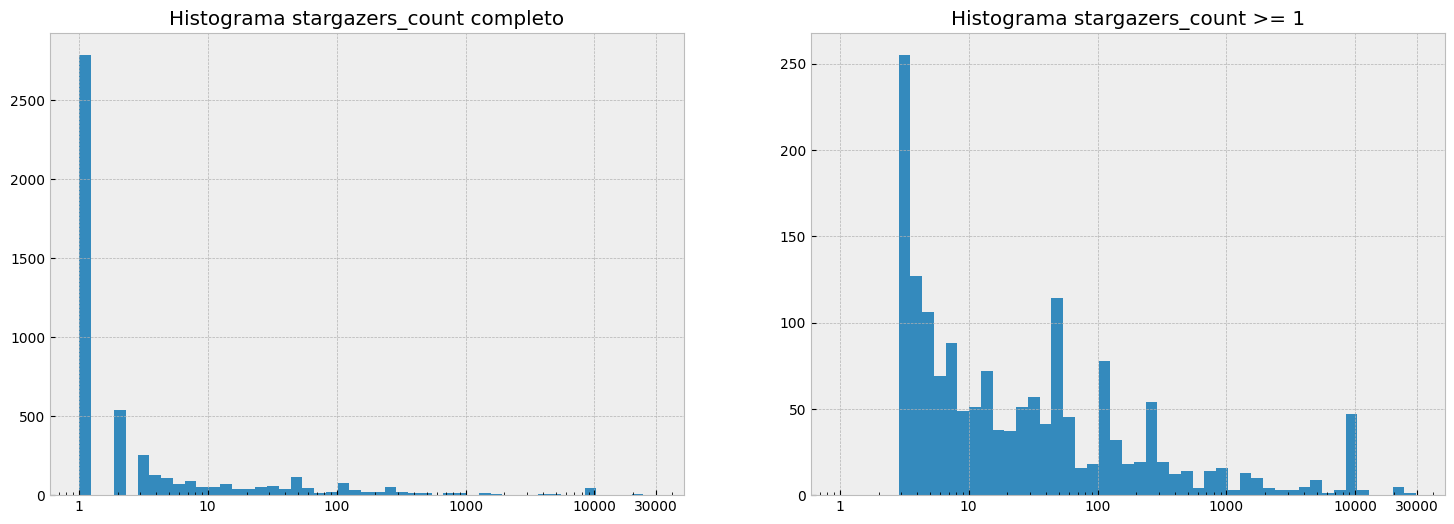

In [24]:
plt.style.use('bmh')
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

data_full = items_details['stargazers_count']
data_filter = filter_min_stars['stargazers_count']

bins_full = np.logspace(0, np.log10(data_full.max() + 1), 50)
bins_filter = np.logspace(0, np.log10(data_filter.max() + 1), 50)

ticks = [1, 10, 100, 1000, 10000, 30000]

axes[0].hist(data_full + 1, bins=bins_full)
axes[0].set_xscale('log')
axes[0].set_xticks(ticks, ticks)
axes[0].set_title("Histograma stargazers_count completo")

axes[1].hist(data_filter + 1, bins=bins_filter)
axes[1].set_xscale('log')
axes[1].set_xticks(ticks, ticks)
axes[1].set_title(f"Histograma stargazers_count >= {min_stars}")

plt.show()


# Analisando created_at e pushed_at

In [25]:
created_at = pd.to_datetime(items_details['created_at'])
pushed_at = pd.to_datetime(items_details['pushed_at'])

print(f"Repositório criado a mais tempo:\t{created_at.min()}\n\
Repositório criado a menos tempo:\t{created_at.max()}")

print(f"Repositório atualizado a mais tempo:\t{pushed_at.min()}\n\
Repositório atualizado a menos tempo:\t{pushed_at.max()}")


Repositório criado a mais tempo:	2011-10-27 05:58:15+00:00
Repositório criado a menos tempo:	2025-03-18 00:12:08+00:00
Repositório atualizado a mais tempo:	2015-12-01 23:05:53+00:00
Repositório atualizado a menos tempo:	2025-04-06 13:07:52+00:00


In [26]:
items_details['life_span'] = items_details['pushed_at'] - \
    items_details['created_at']

display(items_details[items_details['life_span']
        == items_details['life_span'].min()])

display(items_details['life_span'].describe())

min_days = 180
print(f"\nMínimo de {min_days} dias")
filter_min_days = items_details[items_details['life_span'].dt.days > min_days]
print(filter_min_days['life_span'].describe())

print("\nPercentil > 0.9 mais longevos")
filter_outliers_life_span = items_details[items_details['life_span']
                                          >= items_details['life_span'].quantile(0.90)]
print(filter_outliers_life_span['life_span'].describe())


,repo_name,file_path,url,stargazers_count,created_at,pushed_at,life_span
4916,zccfzcc/docker-images,prometheus/production/example-app/example-app-...,https://github.com/zccfzcc/docker-images/blob/...,0.0,2019-09-18 02:54:06+00:00,2019-04-24 09:33:37+00:00,-147 days +06:39:31


count                           4946
mean     547 days 20:02:03.501010920
std      749 days 23:04:02.091079112
min              -147 days +06:39:31
25%          15 days 03:00:55.500000
50%                167 days 04:48:34
75%         846 days 00:04:59.750000
max               4662 days 18:25:04
Name: life_span, dtype: object


Mínimo de 180 dias
count                            2425
mean     1076 days 12:31:53.210721648
std       772 days 04:28:07.351148296
min                 182 days 01:20:12
25%                 439 days 22:08:13
50%                 867 days 17:28:16
75%                1506 days 04:19:48
max                4662 days 18:25:04
Name: life_span, dtype: object

Percentil > 0.9 mais longevos
count                             495
mean     2292 days 16:43:47.892929280
std       572 days 13:03:18.270711720
min                1704 days 22:03:49
25%                1804 days 05:29:46
50%                2108 days 00:16:20
75%         2633 days 19:13:34.500000
max                4662 days 18:25:04
Name: life_span, dtype: object


In [27]:
display(items_details['pushed_at'].describe())

limit_oldest_pushed_at = (datetime.today() - timedelta(days=360)).replace(
    hour=0, minute=0, second=0, microsecond=0, tzinfo=ZoneInfo('GMT'))
print(f"\npushed_at mais recentes do que {limit_oldest_pushed_at}")
filter_newer_pushed_at = items_details[items_details['pushed_at']
                                       > limit_oldest_pushed_at]
print(filter_newer_pushed_at['pushed_at'].describe())

print("\nPercentil >= 0.9 mais recentes")
filter_outliers_life_span = items_details[items_details['pushed_at']
                                          >= items_details['pushed_at'].quantile(0.90)]
print(filter_outliers_life_span['pushed_at'].describe())


count                                   4946
mean     2024-02-05 18:27:58.097047808+00:00
min                2015-12-01 23:05:53+00:00
25%      2023-07-29 16:03:44.750000128+00:00
50%         2024-09-02 10:06:08.500000+00:00
75%         2025-03-10 14:51:23.500000+00:00
max                2025-04-06 13:07:52+00:00
Name: pushed_at, dtype: object


pushed_at mais recentes do que 2024-04-11 00:00:00+00:00
count                                   3103
mean     2024-12-21 09:16:01.963261440+00:00
min                2024-04-11 00:28:10+00:00
25%                2024-09-27 18:10:12+00:00
50%                2025-01-22 00:26:56+00:00
75%                2025-04-01 20:29:34+00:00
max                2025-04-06 13:07:52+00:00
Name: pushed_at, dtype: object

Percentil >= 0.9 mais recentes
count                                    496
mean     2025-04-05 13:31:23.756048640+00:00
min                2025-04-04 17:32:29+00:00
25%                2025-04-05 00:04:06+00:00
50%                2025-04-05 16:07:17+00:00
75%                2025-04-06 01:14:02+00:00
max                2025-04-06 13:07:52+00:00
Name: pushed_at, dtype: object


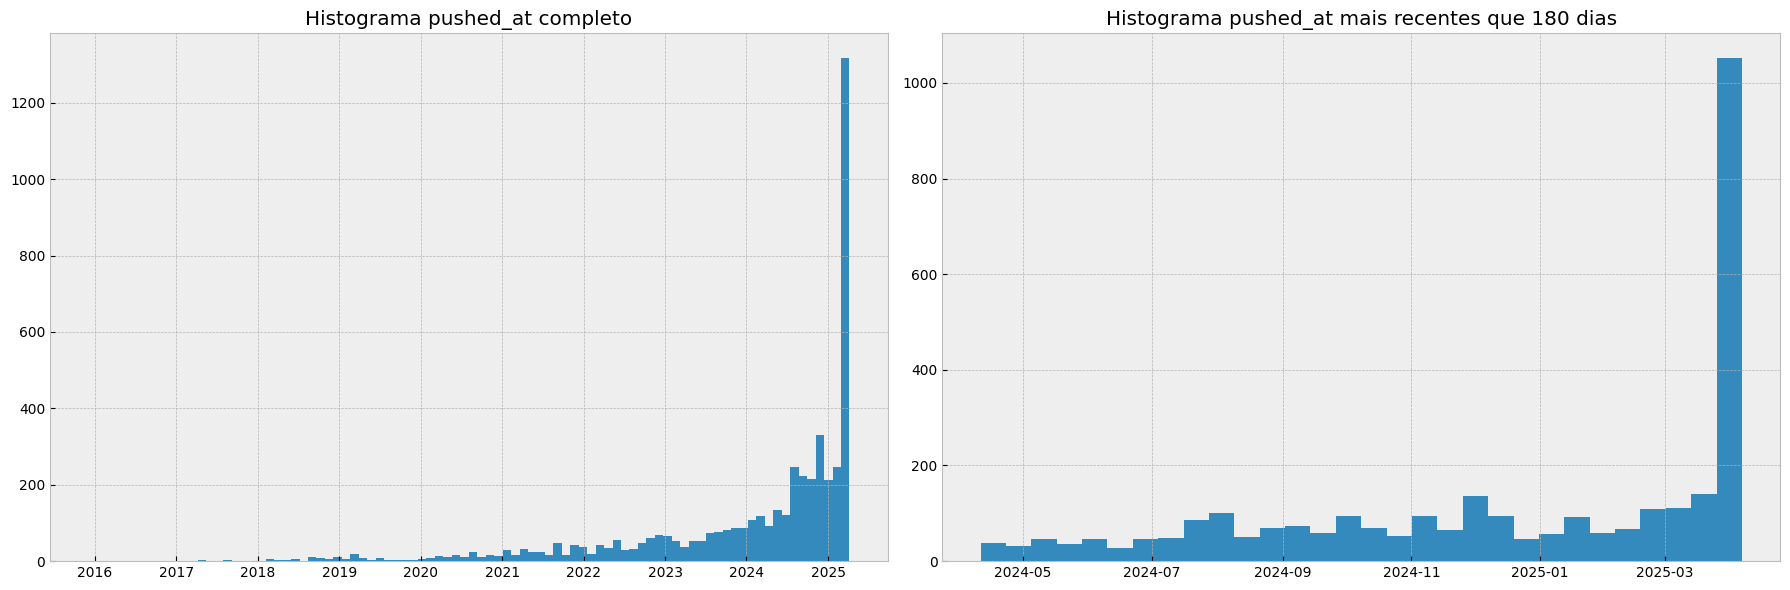

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

data_full = items_details['pushed_at']
data_filter = filter_newer_pushed_at['pushed_at']

# bins_full = np.logspace(0, np.log10(data_full.max() + 1), 50)
# bins_filter = np.logspace(0, np.log10(data_filter.max() + 1), 50)

ticks = [1, 10, 100, 1000, 10000, 30000]

axes[0].hist(data_full, bins=90)
# axes[0].set_xticks(ticks, ticks)
axes[0].set_title("Histograma pushed_at completo")

axes[1].hist(data_filter, bins=30)
# axes[1].set_xticks(ticks, ticks)
axes[1].set_title("Histograma pushed_at mais recentes que 180 dias")

plt.tight_layout()
plt.show()


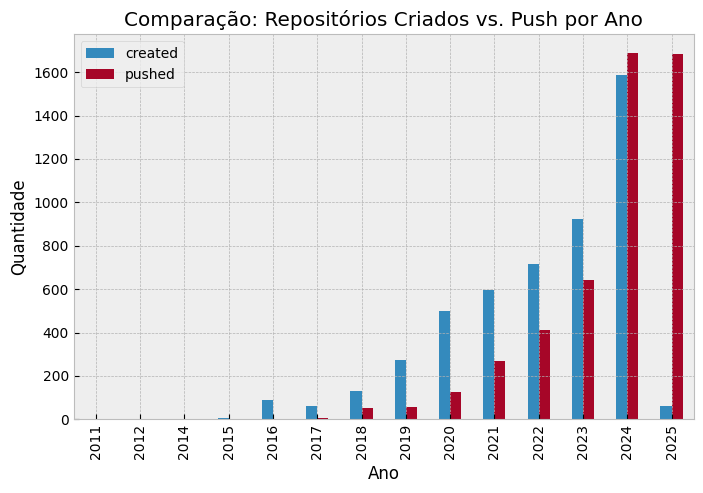

In [29]:
items_details['created_at'] = pd.to_datetime(items_details['created_at'])
items_details['pushed_at'] = pd.to_datetime(items_details['pushed_at'])

items_details['created_year'] = items_details['created_at'].dt.year
items_details['pushed_year'] = items_details['pushed_at'].dt.year

created_year_count = items_details.groupby('created_year')['repo_name'].count()
pushed_year_count = items_details.groupby('pushed_year')['repo_name'].count()

df_anos = pd.DataFrame({
    'created': created_year_count,
    'pushed': pushed_year_count
})

df_anos.plot(kind='bar', figsize=(8, 5))
plt.title('Comparação: Repositórios Criados vs. Push por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade')
plt.show()


# Filtrando por Número de Estrelas

In [31]:
filtered_items = filter_min_stars.sort_values(by=['stargazers_count'])
filtered_items


,repo_name,file_path,url,stargazers_count,created_at,pushed_at
1,0GiS0/tour-of-heroes-gitops-demos,helm/tour-of-heroes-chart/charts/api/templates...,https://github.com/0GiS0/tour-of-heroes-gitops...,2.0,2022-05-02 18:37:39+00:00,2023-08-01 07:52:38+00:00
4927,zeus-fyi/olympus,helm/eth-indexer/templates/hpa.yaml,https://github.com/zeus-fyi/olympus/blob/d7ed8...,2.0,2022-07-07 18:46:13+00:00,2024-10-27 22:43:55+00:00
4918,zeet-dev/helm-charts,charts/posthog/templates/events-hpa.yaml,https://github.com/zeet-dev/helm-charts/blob/a...,2.0,2022-06-07 18:13:11+00:00,2024-02-29 02:37:27+00:00
4894,yokawasa/aksworkshop,examples/captureorder-hpa.yaml,https://github.com/yokawasa/aksworkshop/blob/5...,2.0,2019-04-21 15:25:13+00:00,2019-04-22 06:39:34+00:00
89,AlexRogalskiy/scala-patterns,k8s/secure/backend/hpa.yaml,https://github.com/AlexRogalskiy/scala-pattern...,2.0,2020-12-13 06:47:41+00:00,2025-04-06 04:59:07+00:00
...,...,...,...,...,...,...
177,Budibase/budibase,charts/budibase/templates/automation-worker-se...,https://github.com/Budibase/budibase/blob/5fb2...,23799.0,2019-06-07 11:03:41+00:00,2025-04-05 11:08:23+00:00
178,Budibase/budibase,charts/budibase/templates/automation-worker-se...,https://github.com/Budibase/budibase/blob/1e97...,23799.0,2019-06-07 11:03:41+00:00,2025-04-05 11:08:23+00:00
2448,grafana/loki,production/helm/loki/templates/querier/hpa.yaml,https://github.com/grafana/loki/blob/8fd8697b9...,25132.0,2018-04-16 09:22:48+00:00,2025-04-05 11:38:49+00:00
4639,transloadit/uppy,packages/@uppy/companion/infra/kube/companion/...,https://github.com/transloadit/uppy/blob/4f045...,29644.0,2015-11-16 12:32:33+00:00,2025-04-04 20:31:49+00:00


In [32]:
timestamp = datetime.now().replace(microsecond=0).isoformat()
filter_min_stars.to_csv(f"partial_results/{timestamp}-phase3.csv", index=False)

In [33]:
phase3 = utils.load_phase3_results()

phase3

,repo_name,file_path,url,stargazers_count,created_at,pushed_at
0,0GiS0/tour-of-heroes-gitops-demos,helm/tour-of-heroes-chart/charts/api/templates...,https://github.com/0GiS0/tour-of-heroes-gitops...,2.0,2022-05-02 18:37:39+00:00,2023-08-01 07:52:38+00:00
1,0hlov3/charts,charts/element-web/templates/hpa.yaml,https://github.com/0hlov3/charts/blob/daca391f...,4.0,2023-04-17 06:54:36+00:00,2025-03-21 14:11:26+00:00
2,18F/identity-dashboard,dockerfiles/application.yaml,https://github.com/18F/identity-dashboard/blob...,25.0,2016-05-09 21:23:58+00:00,2025-04-04 22:26:50+00:00
3,18F/identity-dashboard,dockerfiles/application.yaml,https://github.com/18F/identity-dashboard/blob...,25.0,2016-05-09 21:23:58+00:00,2025-04-04 22:26:50+00:00
4,18F/identity-dashboard,dockerfiles/application.yaml,https://github.com/18F/identity-dashboard/blob...,25.0,2016-05-09 21:23:58+00:00,2025-04-04 22:26:50+00:00
...,...,...,...,...,...,...
1621,zhaodangxue/Minik8s,controller/src/HPAController/test/hpa-example....,https://github.com/zhaodangxue/Minik8s/blob/b1...,3.0,2024-07-03 07:37:00+00:00,2024-07-11 14:33:04+00:00
1622,zhaodangxue/Minik8s,apiobjects/examples/pod/hpa-example.yaml,https://github.com/zhaodangxue/Minik8s/blob/b1...,3.0,2024-07-03 07:37:00+00:00,2024-07-11 14:33:04+00:00
1623,zjzjzjzj1874/best-practice-go-zero,task/task-k8s.yaml,https://github.com/zjzjzjzj1874/best-practice-...,10.0,2022-06-06 09:46:12+00:00,2025-02-08 06:13:19+00:00
1624,zuisong/vertx-server-push,k8s.yml,https://github.com/zuisong/vertx-server-push/b...,3.0,2021-03-08 07:59:57+00:00,2025-03-24 06:13:37+00:00


In [36]:
Parallel(n_jobs=2)(
    delayed(download_file)(row) for _, row in phase3.iterrows()
)

# for _, row in filter_min_stars.iterrows():
#   download_file(row)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,